# Homework Week 2 - Language Evolution

This notebook implements a simple version of the language evolution procedure we saw in the papers: 

Steels, Luc, and Martin Loetzsch. "The grounded naming game." Experiments in cultural language evolution 3 (2012): 41-59.

Eyre, Henrietta, and Jonathan Lawry. "Language games with vague categories and negations." Adaptive Behavior 22.5 (2014): 289-303.

In [5]:
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy

# np.random.seed(0)
# random.seed(0)

## Generating data

In [92]:
#This code gives a toy dataset for you to use in running the code for the first time. 
prototypes = np.array([[7, 8],[7.5, 7],[9, 4.5],[4, 2], [6, 2]])
stdevs = np.array([1, 0.3, 0.7, 0.8, 0.7, 0.7])
k = len(prototypes)
data = {}
for i in range(k):
    pts = np.random.multivariate_normal(prototypes[i], (stdevs[i]**2)*np.eye(2), 50)
    data[i] = np.array(pts)

flat_data = np.array([point for key in data for point in data[key]])

Below, add code to import your own dataset if you are using one

In [7]:
#Import your dataset here

## Agents
Each agent consists of a list of concepts. The concepts are each specified by one prototypical point, and any other parameters that may be needed.

In [52]:
# Set up agents.
# Agents have the prototypes of their concepts and any other parameters that are needed.
num_agents = 4
num_concepts = 5
dim = 2
agents = {i: list(zip(np.random.rand(num_concepts, dim)*10, 
                      [1 for i in range(num_concepts)])) for i in range(num_agents)}

## Membership function

In [162]:
#This function implements the membership function
def mu(c, point):
    prototype = c[0]
    decay_parameter = c[1]
    dist = np.linalg.norm(prototype-point)
    m = np.exp(-decay_parameter*dist)
    return m

In [188]:
#Implement the membership function with threshold theta~U([0, 2])
def mu(c, point):
    prototype = c[0]
    decay_parameter = c[1]
    dist = np.linalg.norm(prototype-point)
    if dist > 2:
        m = 0
    else:
        m = np.exp(-decay_parameter*dist)
    return m

## Naming points
The speaker agent names the point it is shown

In [189]:
# This function takes an agent and a datapoint, and returns a label
def name_point(agent, point):
    memberships = [mu(c, point) for c in agent]
    summed_memberships = np.cumsum(memberships)
    dice = np.random.rand()*sum(memberships)
    label = next(i for i, v in enumerate(summed_memberships) if v >= dice)
    return label

## Updating concepts
The listener agent updates its concepts based on the label that the speaker agent asserts.

In [190]:
# This function takes an agent, a label, a point, and some extra parameters, and updates the agent's concepts
def update_concepts(agent, label, point, h, lims):
    new_agent = agent
    mus = []
    if label is not None:
        prototype = agent[label][0]
        decay_parameter = agent[label][1]
        prototype = (1 - h)*prototype + h*point
        for i in range(len(lims)):
            if prototype[i] < lims[i][0]:
                prototype[i] = lims[i][0]
            elif prototype[i] > lims[i][1]:
                prototype[i] = lims[i][1]
        new_agent[label] = (prototype, decay_parameter)
    else:
        pass
    return new_agent

In [191]:
#Implement your modification of update_concepts here

## Play one iteration of the game
This function randomly selects a pair of agents and a point, and plays the game.

In [192]:
# This function runs one iteration of the game.
def play_game(agent_array, dataset, h, lims):
    s, l = random.sample(list(agent_array), 2)
    speaker = agent_array[s]
    listener = agent_array[l]
    point = random.choice(dataset)
    label = name_point(speaker, point)
    new_listener = update_concepts(listener, label, point, h, lims)
    agent_array[l] = new_listener
    return agent_array
    

## Metrics
APD measures the distance between prototypes for the same labels across pairs of agents.

ALO measures the overlap between labels for each agent and then takes the average.

In [193]:
# Calculates the average pairwise distance between agents
def calculate_APD(agent_array):
    dists = []
    agent_pairs = itertools.combinations(agent_array, 2)
    for (p1, p2) in agent_pairs:
        a1 = agent_array[p1]
        a2 = agent_array[p2]
        dists += [np.linalg.norm(a1[i][0] - a2[i][0]) for i, _ in enumerate(a1)]
    apd = np.mean(dists)
    return apd
    
    

In [194]:
# Calculates average label overlap
def calculate_ALO(agent_array, dataset):
    overlap = []
    for agent in agent_array:
        concept_pairs = itertools.combinations(agent_array[agent], 2)
        overlap += [max([min(mu(c1, point), mu(c2, point)) for point in dataset]) for (c1, c2) in concept_pairs]
    alo = np.mean(overlap)

    return alo

In [195]:
# Run the simulation
def run_sim(agent_array, dataset, num_its, h,  lims):
    new_array = copy.deepcopy(agent_array)
    apd_scores = []
    alo_scores = []
    for i in range(num_its):
        new_array = play_game(new_array, dataset, h, lims)
        if i % 10 == 0:
            apd_scores.append(calculate_APD(new_array))
            alo_scores.append(calculate_ALO(new_array, dataset))
    return new_array, apd_scores, alo_scores

In [196]:
# Run simulation
new_agents, apd_sc, alo_sc = run_sim(agents, flat_data, 2000, 0.1, [[0, 10], [0, 10]])

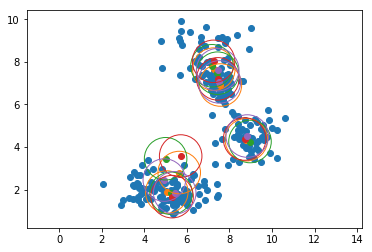

In [197]:
fig, ax = plt.subplots()
x, y = flat_data.T
plt.scatter(x, y)
cols = ['C1', 'C2', 'C3', 'C4', 'C5']
for i, a in enumerate(new_agents):
    ptypes= []
    stdevs=[]
    for c in new_agents[a]:
        ptypes.append(c[0])
        stdevs.append(c[1])
    ptypes = np.array(ptypes)
    x, y = ptypes.T
    plt.scatter(x, y, color = cols[i])
    for j,s in enumerate(stdevs):
        # Draws circles at one standard deviation from the prototype, which is 1/decay_parameter for the exponential distribution
        patch = patches.Circle(ptypes[j], radius=1/s, edgecolor=cols[i],facecolor='none')
        ax.add_patch(patch)
    plt.axis("equal")
        
    


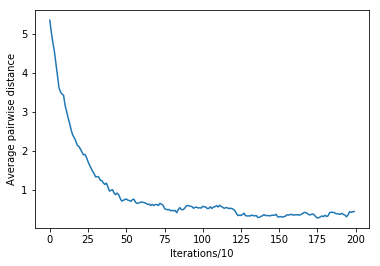

In [198]:
plt.plot(apd_sc)
plt.xlabel("Iterations/10")
plt.ylabel("Average pairwise distance")
plt.show()

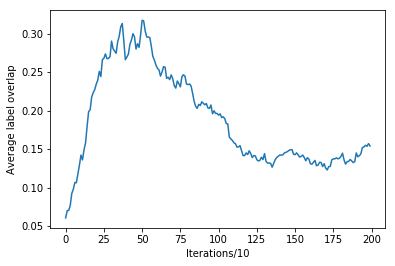

In [199]:
plt.plot(alo_sc)
plt.xlabel("Iterations/10")
plt.ylabel("Average label overlap")
plt.show()